In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
from scipy.interpolate import RectBivariateSpline
import numpy as np

In [3]:
from vaneska.interpolate import ScipyRectBivariateSpline

In [4]:
from lightkurve import KeplerTargetPixelFile

In [5]:
import tensorflow as tf

In [6]:
from vaneska.models import KeplerPRF

In [7]:
tpf = KeplerTargetPixelFile.from_archive('kepler-10b', quarter=5)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2010174085026_lpd-targ.fits.gz with expected size 4685387. [astroquery.query]


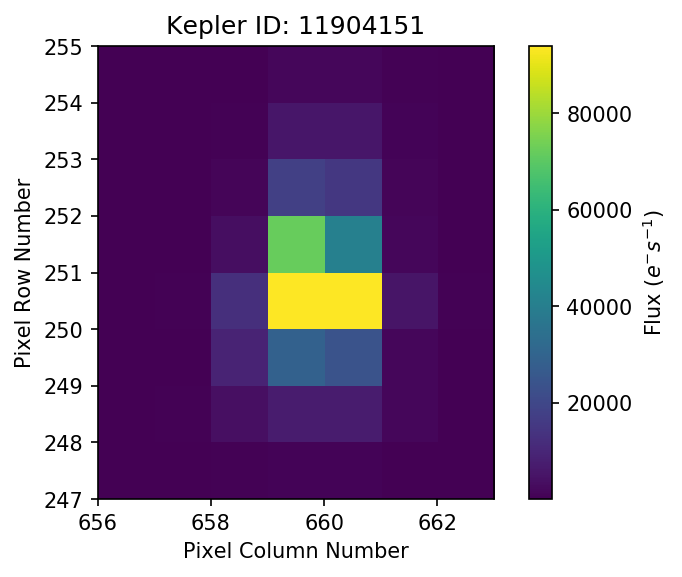

In [8]:
tpf.plot()

In [9]:
tpf.shape

(4492, 8, 7)

In [10]:
prf = KeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [11]:
flux0 = np.nansum(tpf.flux[0])
xc0, yc0 = tpf.centroids()[0][0], tpf.centroids()[1][0]
bkg0 = np.nanmean(tpf.flux_bkg[0])

In [12]:
flux = tf.Variable(flux0, dtype=tf.float64)
xc = tf.Variable(xc0, dtype=tf.float64)
yc = tf.Variable(yc0, dtype=tf.float64)
bkg = tf.Variable(bkg0, dtype=tf.float64)

In [13]:
var_list = [flux, xc, yc, bkg]

In [14]:
model = prf(flux, xc, yc) + bkg

In [15]:
model

<tf.Tensor 'add:0' shape=<unknown> dtype=float64>

In [16]:
sess = tf.Session()

In [17]:
sess.run(tf.global_variables_initializer())

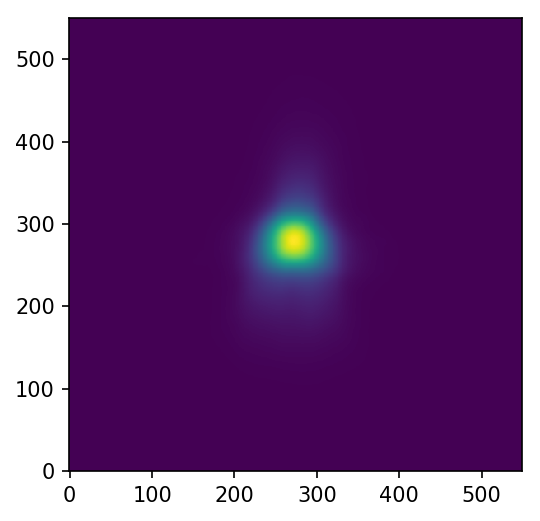

In [18]:
plt.imshow(prf.supersampled_prf, origin='lower')

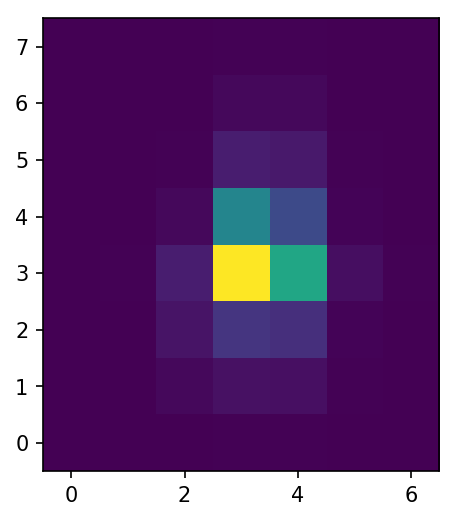

In [19]:
plt.imshow(sess.run(model), origin='lower')

In [20]:
data = tf.placeholder(dtype=tf.float64, shape=tpf.flux[0].shape)

In [21]:
loss = tf.reduce_sum(tf.subtract(model, tf.multiply(data, tf.log(model))))

In [22]:
grad = tf.gradients(loss, var_list)

In [23]:
sess.run(grad, feed_dict={data:tpf.flux[0] + tpf.flux_bkg[0]})

[0.0051697983761433064,
 -46041.183732750273,
 4017.7438244003934,
 -5.0464005414592599]

In [24]:
sess.run(loss, feed_dict={data:tpf.flux[-1] + tpf.flux_bkg[-1]})

-5427779.1072407272

In [25]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, var_list, method='BFGS')

In [26]:
import tqdm

In [ ]:
psf_flux = []
psf_xc = []
psf_yc = []
psf_bkg = []
for n in tqdm.tqdm(range(len(tpf.time))):
    optimizer.minimize(session=sess, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]})
    psf_flux.append(sess.run(flux))
    psf_xc.append(sess.run(xc))
    psf_yc.append(sess.run(yc))
    psf_bkg.append(sess.run(bkg))
    print(sess.run(grad, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]}))

  0%|          | 0/4492 [00:00<?, ?it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511108.791246
  Number of iterations: 37
  Number of functions evaluations: 44


  0%|          | 1/4492 [00:00<30:12,  2.48it/s]

[3.4150363266427508e-10, -5.1347370117582614e-05, 4.9666723498376086e-06, 1.2719393205351537e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510920.137101
  Number of iterations: 11
  Number of functions evaluations: 15


  0%|          | 2/4492 [00:00<19:43,  3.79it/s]

[3.1912031260026077e-06, -0.00018592776450532256, -1.8387599993729964e-05, 3.9346110924931565e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511383.378077
  Number of iterations: 36
  Number of functions evaluations: 40


  0%|          | 3/4492 [00:00<20:52,  3.58it/s]

[-9.5319778979641168e-11, -2.3835378215153469e-05, -6.4854611991904676e-07, -1.8715866412222226e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511830.355447
  Number of iterations: 35
  Number of functions evaluations: 39


  0%|          | 4/4492 [00:01<20:58,  3.57it/s]

[-1.1150366307360882e-10, -0.00020752131331391865, 0.00011067549166909885, 9.5437456049118907e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511982.104563
  Number of iterations: 13
  Number of functions evaluations: 79


  0%|          | 5/4492 [00:01<24:46,  3.02it/s]

[-7.3820405039216191e-07, -7.1453815962740919e-05, 7.5864718382945284e-06, -6.7801201319994675e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511765.760628
  Number of iterations: 11
  Number of functions evaluations: 15


  0%|          | 6/4492 [00:01<22:13,  3.36it/s]

[-2.3751161184617543e-05, -0.0088630871987334103, 0.0048827105874806875, 4.4288835402417348e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511875.210320
  Number of iterations: 27
  Number of functions evaluations: 34


  0%|          | 7/4492 [00:02<22:11,  3.37it/s]

[1.9854223352183675e-09, 0.0013311021793924738, 0.00094338515191338956, 4.7668089941943492e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511979.997315
  Number of iterations: 23
  Number of functions evaluations: 35


  0%|          | 8/4492 [00:02<21:50,  3.42it/s]

[4.5238393846930292e-10, 0.00023800684675734374, -0.0010778528830996947, -1.7123858664369607e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512285.046083
  Number of iterations: 8
  Number of functions evaluations: 12


  0%|          | 9/4492 [00:02<20:19,  3.68it/s]

[-5.9589810987945718e-06, -0.0072363839508398087, 0.0044103038271714468, 2.8442587807209208e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512067.741150
  Number of iterations: 9
  Number of functions evaluations: 73


  0%|          | 10/4492 [00:02<22:14,  3.36it/s]

[-2.083378477357907e-06, 0.0051229696305199468, -0.0020231123999110423, -2.7156049506871227e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511282.749685
  Number of iterations: 35
  Number of functions evaluations: 90


  0%|          | 11/4492 [00:03<24:23,  3.06it/s]

[-1.6937474122888374e-09, 0.0012663963693739788, -0.0011601824953686446, -1.3361145900780969e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512750.981508
  Number of iterations: 37
  Number of functions evaluations: 43


  0%|          | 12/4492 [00:03<24:14,  3.08it/s]

[-1.1398017946140371e-12, -6.3939296524040401e-08, 1.2905729818157852e-08, -1.1286749312944266e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511762.999789
  Number of iterations: 8
  Number of functions evaluations: 81


  0%|          | 13/4492 [00:04<26:31,  2.81it/s]

[1.6284630077733134e-05, 0.00040705769288251759, 3.2091760658659041e-05, 4.193065018531783e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511570.317667
  Number of iterations: 36
  Number of functions evaluations: 41


  0%|          | 14/4492 [00:04<26:15,  2.84it/s]

[4.7411237262540151e-11, -8.6040681708254851e-06, -1.0500240023247898e-05, 6.0664566703394485e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508140.463300
  Number of iterations: 37
  Number of functions evaluations: 89


  0%|          | 15/4492 [00:05<27:47,  2.69it/s]

[3.6439912632496574e-10, 9.5468931249342859e-06, 1.3777495041722432e-05, -1.2076529087856613e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512187.480694
  Number of iterations: 35
  Number of functions evaluations: 90


  0%|          | 16/4492 [00:06<29:15,  2.55it/s]

[-2.9401622516841974e-09, 0.0095693548819326679, 0.0087667873904138105, -7.4541677879125245e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512738.413711
  Number of iterations: 32
  Number of functions evaluations: 40


  0%|          | 17/4492 [00:06<29:08,  2.56it/s]

[-7.4942900843422144e-11, 9.8819747108791489e-05, -8.565217285649851e-06, -1.1943013800141955e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513250.190145
  Number of iterations: 34
  Number of functions evaluations: 87


  0%|          | 18/4492 [00:07<30:09,  2.47it/s]

[3.4424767134111356e-09, 0.001762117813086661, 0.0011687900150718633, 1.7014583040264597e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512937.012207
  Number of iterations: 35
  Number of functions evaluations: 39


  0%|          | 19/4492 [00:07<30:02,  2.48it/s]

[8.0782772832188598e-11, -0.00010870972391785472, 8.3740193076664582e-05, 3.1063140948361934e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512679.738348
  Number of iterations: 11
  Number of functions evaluations: 14


  0%|          | 20/4492 [00:07<29:06,  2.56it/s]

[6.3559215638959304e-07, 5.0217295211041346e-06, -2.3775846784701571e-06, 5.1341629836443303e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512849.972169
  Number of iterations: 12
  Number of functions evaluations: 17


  0%|          | 21/4492 [00:07<28:19,  2.63it/s]

[-6.6558766290787316e-06, -0.00012828033959522145, 2.3858028725953773e-05, -1.7802368934560775e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512777.851091
  Number of iterations: 12
  Number of functions evaluations: 16


  0%|          | 22/4492 [00:08<27:32,  2.71it/s]

[-4.2890722791706984e-06, 0.00040946462968349806, -2.1183961507631466e-05, 1.5542964582060392e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511974.958921
  Number of iterations: 38
  Number of functions evaluations: 43


  1%|          | 23/4492 [00:08<27:19,  2.73it/s]

[3.7783797791901552e-11, 2.4073651729850098e-06, -2.1872983779758215e-07, -6.8532240993235405e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512485.226591
  Number of iterations: 35
  Number of functions evaluations: 39


  1%|          | 24/4492 [00:08<27:11,  2.74it/s]

[-2.8737223538299883e-10, 0.00011284099309705198, 6.8942053985665552e-05, -9.3237778941990257e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512504.502007
  Number of iterations: 31
  Number of functions evaluations: 38


  1%|          | 25/4492 [00:09<26:54,  2.77it/s]

[-3.9617136828040689e-11, 8.4164800682628993e-05, -3.456962076597847e-06, -2.653073649661053e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513457.898994
  Number of iterations: 36
  Number of functions evaluations: 39


  1%|          | 26/4492 [00:09<26:38,  2.79it/s]

[-2.5995550330393247e-11, 9.0484804786683526e-06, -2.6453981263330206e-06, -1.8593888650997314e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513275.931658
  Number of iterations: 34
  Number of functions evaluations: 38


  1%|          | 27/4492 [00:09<26:23,  2.82it/s]

[4.2275718776380034e-10, -0.00076142518719279906, 0.0004666126988013275, 6.5148257688552036e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513587.954264
  Number of iterations: 36
  Number of functions evaluations: 123


  1%|          | 28/4492 [00:10<27:35,  2.70it/s]

[2.3853285163050186e-09, -0.004567117728129233, 0.0066212078454555012, 4.1629105052010118e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513815.049686
  Number of iterations: 12
  Number of functions evaluations: 88


  1%|          | 29/4492 [00:10<28:07,  2.65it/s]

[-5.558739527797632e-06, 2.0970914192730561e-05, -0.00030320473706524353, 6.7878232812290662e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514297.311918
  Number of iterations: 37
  Number of functions evaluations: 51


  1%|          | 30/4492 [00:11<28:03,  2.65it/s]

[-6.4048431488994417e-11, 2.0445395421120338e-06, 1.4726032532053068e-05, -1.2742512600638634e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514004.339570
  Number of iterations: 36
  Number of functions evaluations: 40


  1%|          | 31/4492 [00:11<27:49,  2.67it/s]

[3.9062378852372515e-10, -0.0001566638788972341, 0.00010463149737915955, 2.3949966143632651e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514077.008906
  Number of iterations: 12
  Number of functions evaluations: 16


  1%|          | 32/4492 [00:11<27:15,  2.73it/s]

[-3.1256230107069155e-06, -5.1357752454350702e-05, 6.3842009694781154e-05, 9.6592164156028559e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514170.210249
  Number of iterations: 31
  Number of functions evaluations: 37


  1%|          | 33/4492 [00:12<27:01,  2.75it/s]

[-7.9793506871372877e-12, -0.0002745096676335379, 0.00016266587954305578, 7.3373433218115736e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514307.882475
  Number of iterations: 33
  Number of functions evaluations: 38


  1%|          | 34/4492 [00:12<26:53,  2.76it/s]

[-3.3166288725822168e-10, 7.7681309448962566e-05, 3.2942903999355622e-05, -2.0289293356512417e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514512.059447
  Number of iterations: 9
  Number of functions evaluations: 68


  1%|          | 35/4492 [00:12<27:20,  2.72it/s]

[4.1339266255886742e-06, -0.00065416788629590883, 0.0018658585231605684, -2.3715355679243544e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514873.527832
  Number of iterations: 35
  Number of functions evaluations: 90


  1%|          | 36/4492 [00:13<27:50,  2.67it/s]

[2.6560383233065199e-11, 0.00036227486589268665, -1.5731526218587533e-05, 1.9045760968339209e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514851.625513
  Number of iterations: 31
  Number of functions evaluations: 37


  1%|          | 37/4492 [00:13<27:40,  2.68it/s]

[-1.4308174176719257e-10, -5.5146284012153046e-05, 2.1542720787692815e-05, -4.7141811565509784e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514474.269476
  Number of iterations: 36
  Number of functions evaluations: 39


  1%|          | 38/4492 [00:14<27:38,  2.69it/s]

[1.0853911519559389e-11, -1.717320174066117e-06, -3.1191302696242929e-07, 1.038597319258372e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514882.138523
  Number of iterations: 36
  Number of functions evaluations: 40


  1%|          | 39/4492 [00:14<27:32,  2.69it/s]

[-4.7810247080781743e-11, 2.3290502213058062e-05, 1.3396876965998672e-05, 1.565318086260703e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514851.338131
  Number of iterations: 34
  Number of functions evaluations: 39


  1%|          | 40/4492 [00:14<27:30,  2.70it/s]

[-3.4412574526077044e-10, -0.00074031183612532914, -0.00041154543760058004, -4.4359530981807893e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514599.751814
  Number of iterations: 38
  Number of functions evaluations: 42


  1%|          | 41/4492 [00:15<27:22,  2.71it/s]

[2.2698684078170661e-11, -2.6215852813038509e-06, -4.3783074943348765e-08, 3.2579092756890304e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515033.805655
  Number of iterations: 34
  Number of functions evaluations: 123


  1%|          | 42/4492 [00:15<28:10,  2.63it/s]

[5.1166205544163346e-08, 0.0063672772016616364, -0.0040170597549149534, 8.0225942663547656e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514949.949265
  Number of iterations: 12
  Number of functions evaluations: 16


  1%|          | 43/4492 [00:16<27:44,  2.67it/s]

[-5.5390902759392194e-06, 0.0027956652143075189, 0.0027845710174005944, 1.1619799699102984e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515358.697161
  Number of iterations: 35
  Number of functions evaluations: 42


  1%|          | 44/4492 [00:16<27:36,  2.69it/s]

[-3.7966967243729943e-11, -0.00017938337987288833, -5.4225851272349246e-05, 6.9971511251765151e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515001.863975
  Number of iterations: 37
  Number of functions evaluations: 41


  1%|          | 45/4492 [00:16<27:27,  2.70it/s]

[4.3618391884492347e-11, -0.00017565367625138606, -0.00021124439990671817, -5.5581568791929215e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515762.569045
  Number of iterations: 32
  Number of functions evaluations: 39


  1%|          | 46/4492 [00:16<27:18,  2.71it/s]

[-4.328293261995908e-10, 9.5670961854921188e-06, -4.8502388381166384e-06, -2.0084574148260259e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515101.021419
  Number of iterations: 26
  Number of functions evaluations: 34


  1%|          | 47/4492 [00:17<27:07,  2.73it/s]

[3.6380617528947168e-10, 0.00012090873497072607, -0.00018681629444472492, 1.5342974779564145e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515773.698358
  Number of iterations: 37
  Number of functions evaluations: 139


  1%|          | 48/4492 [00:18<28:06,  2.63it/s]

[1.4763670754674996e-10, -0.00016298139007631107, 0.0032991978059726534, -3.8562405080266871e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515928.540525
  Number of iterations: 31
  Number of functions evaluations: 39


  1%|          | 49/4492 [00:18<27:57,  2.65it/s]

[-1.3126234214150267e-10, 8.3840848219551845e-05, 0.00033628697383392137, -3.318792550777161e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515491.299930
  Number of iterations: 25
  Number of functions evaluations: 70


  1%|          | 50/4492 [00:19<28:08,  2.63it/s]

[8.8472162755592887e-11, -3.4447012239979813e-05, 6.3715015130583197e-05, -4.4195066384311588e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515268.318115
  Number of iterations: 29
  Number of functions evaluations: 37


  1%|          | 51/4492 [00:19<27:57,  2.65it/s]

[4.4811980515202521e-11, 9.7165730039705522e-06, 3.1813066016184166e-05, -8.6072926563929286e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515639.622082
  Number of iterations: 20
  Number of functions evaluations: 30


  1%|          | 52/4492 [00:19<27:43,  2.67it/s]

[6.0369062179765898e-11, 0.0001787073201739986, 8.9037261204794049e-05, 1.9632158565485724e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515362.121215
  Number of iterations: 24
  Number of functions evaluations: 77


  1%|          | 53/4492 [00:20<28:02,  2.64it/s]

[-4.5709825100340162e-09, 5.3364897667051991e-05, 0.0039512921375717269, -9.4375806425350817e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515578.229005
  Number of iterations: 36
  Number of functions evaluations: 41


  1%|          | 54/4492 [00:20<27:55,  2.65it/s]

[-5.1378719854999755e-11, 5.8708660617412534e-06, -1.4135965102468617e-05, -7.4338487587866098e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516110.699043
  Number of iterations: 11
  Number of functions evaluations: 84


  1%|          | 55/4492 [00:20<28:12,  2.62it/s]

[-9.4740816123182331e-06, -0.0033598126101423986, -0.0026412464740133146, 5.8824363879939057e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515491.653320
  Number of iterations: 37
  Number of functions evaluations: 45


  1%|          | 56/4492 [00:21<28:11,  2.62it/s]

[4.1971257198902823e-11, -0.00043179092608625069, 4.516527769737877e-05, -1.5296711453061107e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5523041.510257
  Number of iterations: 25
  Number of functions evaluations: 37


  1%|▏         | 57/4492 [00:21<28:02,  2.64it/s]

[5.1578602500157444e-11, 5.0884013944596518e-06, -3.0637038435088471e-06, -7.1751779295858853e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515876.099928
  Number of iterations: 24
  Number of functions evaluations: 39


  1%|▏         | 58/4492 [00:21<28:00,  2.64it/s]

[-1.1374143293885197e-10, -1.1765079307224369e-05, 5.1028728194069117e-06, 2.5025091909824937e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515795.205312
  Number of iterations: 36
  Number of functions evaluations: 105


  1%|▏         | 59/4492 [00:22<28:26,  2.60it/s]

[5.3609126512976779e-10, -0.0007802353497936565, 9.8919976153410971e-05, 5.6544216742171471e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515668.281077
  Number of iterations: 11
  Number of functions evaluations: 15


  1%|▏         | 60/4492 [00:22<28:06,  2.63it/s]

[-1.6699733261156015e-05, 0.0036288224810050451, 0.0022173069301061332, 2.2462367865738742e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515698.930251
  Number of iterations: 28
  Number of functions evaluations: 34


  1%|▏         | 61/4492 [00:23<27:59,  2.64it/s]

[-4.1555838631301967e-12, -2.8290423870203085e-07, 3.2064963306766003e-07, -4.0127079437013435e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515808.968836
  Number of iterations: 33
  Number of functions evaluations: 106


  1%|▏         | 62/4492 [00:23<28:27,  2.59it/s]

[-4.8843200924769681e-10, 0.0010086317247441912, 0.0013271519328554859, 7.8546569104442909e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514988.170815
  Number of iterations: 35
  Number of functions evaluations: 103


  1%|▏         | 63/4492 [00:24<28:48,  2.56it/s]

[1.1403567734200037e-09, 0.00051993290571772377, -6.8252511482569389e-05, 2.3637488596461864e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514818.067675
  Number of iterations: 10
  Number of functions evaluations: 14


  1%|▏         | 64/4492 [00:24<28:29,  2.59it/s]

[3.086769405343491e-05, -0.0029476716554199811, 0.00099756628515024204, -7.9033179478660287e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515323.852202
  Number of iterations: 33
  Number of functions evaluations: 89


  1%|▏         | 65/4492 [00:25<28:43,  2.57it/s]

[-8.2359207734944428e-10, -3.7044801956653828e-05, 2.4656595996930264e-05, -4.8443450606505678e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515908.448819
  Number of iterations: 34
  Number of functions evaluations: 89


  1%|▏         | 66/4492 [00:25<28:59,  2.55it/s]

[-3.1213957720627183e-10, -0.00057158907020493643, 0.00036683414327853825, -1.5067888159414622e-08]


In [ ]:
plt.plot(tpf.time, psf_flux, 'ko', markersize=1)

In [ ]:
from lightkurve import LightCurve

In [ ]:
lc_psf = LightCurve(tpf.time, psf_flux)

In [ ]:
lc_aper = tpf.to_lightcurve()

In [ ]:
plt.plot(tpf.time, psf_flux, 'ko', markersize=1)
plt.plot(lc_aper.time, lc_aper.flux, 'rx', markersize=1)

In [ ]:
lc_aper = lc_aper.flatten().fold(.837495)

In [ ]:
lc_psf = lc_psf.flatten().fold(.837495)

In [ ]:
plt.plot(lc_aper.time, lc_aper.flux, 'ro', markersize=1, label='Aperture', alpha=.3)
plt.plot(lc_psf.time, lc_psf.flux, 'ko', markersize=1, label='PSF', alpha=.3)
plt.legend(numpoints=3)

In [ ]:
100 * (1 - lc_psf.cdpp() / lc_aper.cdpp())